In [19]:
!nvidia-smi

Tue Oct  7 15:31:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             36W /   70W |    1752MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
!git clone https://github.com/Omid-Nejati/MedViT.git

Cloning into 'MedViT'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 194 (delta 95), reused 87 (delta 87), pack-reused 92 (from 1)
Receiving objects: 100% (194/194), 819.25 KiB | 2.54 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [21]:
cd /content/MedViT

/content/MedViT


In [22]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary


##Model

In [23]:
!pip install timm
!pip install einops

In [24]:
from MedViT import MedViT_small as tiny

In [25]:
model = tiny()

initialize_weights...


In [26]:
model.proj_head[0]

Linear(in_features=1024, out_features=1000, bias=True)

In [27]:
model.proj_head[0] = torch.nn.Linear(in_features=1024, out_features=2, bias=True)

In [28]:
model = model.cuda()

##Dataset

In [29]:
!pip install medmnist

In [30]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

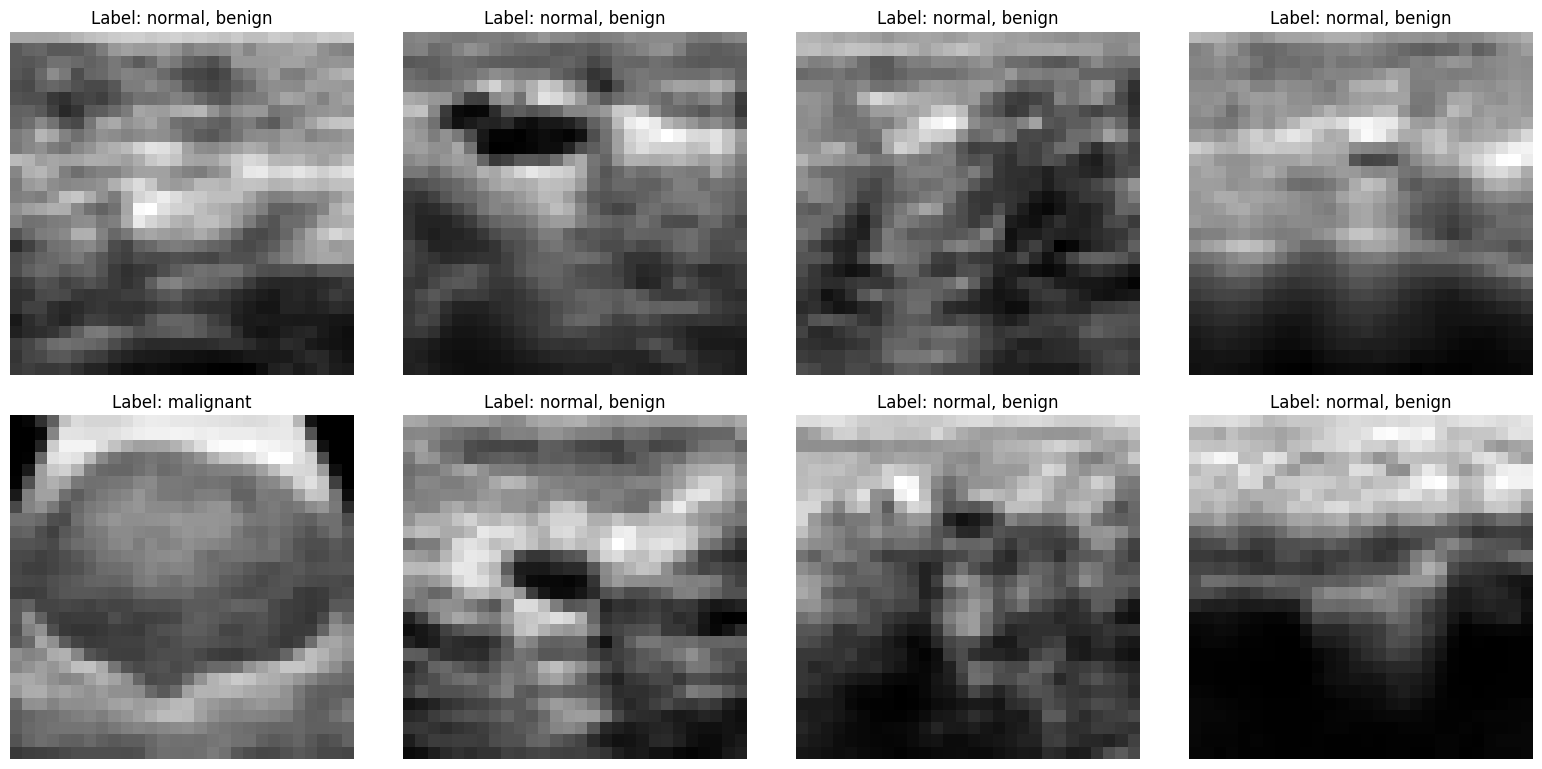

In [51]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from medmnist import INFO

# 1. 选择数据集（可替换为任意 medmnist 数据集）
data_flag = 'breastmnist'  # 例：'chestmnist'/'dermamnist'/'retinamnist'
download = True  # 首次运行下载，后续设为 False

# 2. 获取数据集信息与类
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# 3. 极简转换：仅转 Tensor（不缩放、不转 RGB，保留原始灰度）
# 关键：无 Resize！保留数据集原生尺寸（如 breastmnist 为 28×28，chestmnist 为 64×64）
show_transform = transforms.Compose([
    transforms.ToTensor()  # 仅转为 Tensor，维度：(1, H, W)（1 代表单通道灰度）
])

# 4. 加载数据集（用原始尺寸）
dataset = DataClass(
    split='train',  # 查看训练集，改 'test' 看测试集
    transform=show_transform,
    download=download
)

# 5. 高清可视化配置
num_samples = 8  # 显示 8 个样本
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 增大窗口尺寸（16×8），子图更宽裕
axes = axes.flatten()

for i in range(num_samples):
    # 提取样本（原始尺寸 Tensor）
    image_tensor, label_tensor = dataset[i]  #  shape: (1, H, W)，label: (1,)

    # 转换格式：(1, H, W) → (H, W)（去掉通道维度，适配灰度显示）
    image_np = image_tensor.squeeze(0).numpy()  # 关键：squeeze 移除多余的通道维度

    # 解析标签（保持易懂）
    if info['task'] == 'multi-label, binary-class':
        positive_labels = [info['label'][str(idx)] for idx in range(len(label_tensor)) if label_tensor[idx] == 1]
        axes[i].set_title(f"Labels: {', '.join(positive_labels)}", fontsize=12)  # 增大标题字体
    else:
        label_idx = label_tensor.item()
        class_name = info['label'][str(label_idx)]
        axes[i].set_title(f"Label: {class_name}", fontsize=12)

    # 高清显示核心：用灰度图+无插值
    axes[i].imshow(
        image_np,
        cmap='gray',  # 医学影像标准灰度配色，细节更突出
        interpolation='none'  # 禁用插值，避免边缘模糊（关键优化！）
    )
    axes[i].axis('off')  # 关闭坐标轴，聚焦图像

# 调整子图间距，避免拥挤
plt.tight_layout(pad=2.0)  # pad 增加间距，防止标题重叠
# 保存高清图片（可选，分辨率 300 DPI，适合论文/报告）
plt.savefig(f"{data_flag}_samples_highres.png", dpi=300, bbox_inches='tight')
# 显示图像
plt.show()

In [39]:
data_flag = 'breastmnist'
# [tissuemnist, pathmnist, chestmnist, dermamnist, octmnist,
# pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 10
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [32]:
from torchvision.transforms.transforms import Resize
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(160),
    transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0

In [33]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: 

## Train

In [34]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [35]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    print('Epoch [%d/%d]'% (epoch+1, NUM_EPOCHS))
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

Epoch [1/10]


100%|██████████| 55/55 [00:15<00:00,  3.54it/s]


Epoch [2/10]


100%|██████████| 55/55 [00:10<00:00,  5.22it/s]


Epoch [3/10]


100%|██████████| 55/55 [00:10<00:00,  5.27it/s]


Epoch [4/10]


100%|██████████| 55/55 [00:10<00:00,  5.48it/s]


Epoch [5/10]


100%|██████████| 55/55 [00:10<00:00,  5.41it/s]


Epoch [6/10]


100%|██████████| 55/55 [00:10<00:00,  5.41it/s]


Epoch [7/10]


100%|██████████| 55/55 [00:10<00:00,  5.38it/s]


Epoch [8/10]


100%|██████████| 55/55 [00:10<00:00,  5.04it/s]


Epoch [9/10]


100%|██████████| 55/55 [00:10<00:00,  5.35it/s]


Epoch [10/10]


100%|██████████| 55/55 [00:10<00:00,  5.33it/s]


##Test

In [36]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([]).cuda()
    y_score = torch.tensor([]).cuda()

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.894  acc:0.824
test  auc: 0.808  acc:0.769
